<a href="https://colab.research.google.com/github/wreckweg/Face_Recognition_Project/blob/main/Complete_data_imaug_Face_rec_drone_Face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 32.9 MB/s eta 0:00:00


In [3]:
import cv2
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from mtcnn.mtcnn import MTCNN

In [5]:
img = cv2.imread('/content/drive/MyDrive/Face_recognisation/DroneFace_dataset/Train_aug/a/a_0_1021.jpeg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

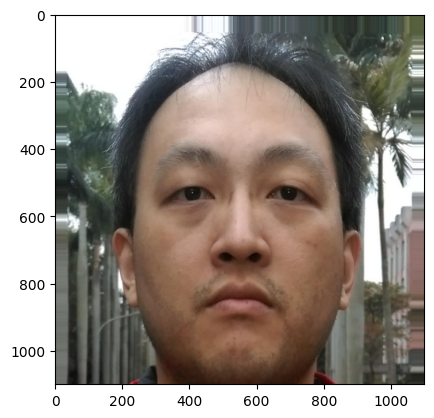

In [6]:
plt.imshow(img)

In [ ]:
detector = MTCNN()
result = detector.detect_faces(img)

In [8]:
result

[{'box': [226, 199, 620, 846],
  'confidence': 0.9999097585678101,
  'keypoints': {'left_eye': (405, 544),
   'right_eye': (693, 543),
   'nose': (554, 682),
   'mouth_left': (440, 868),
   'mouth_right': (659, 874)}}]

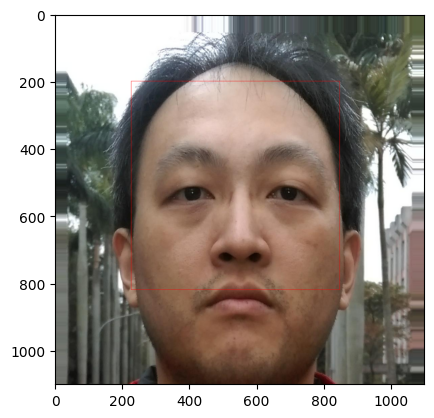

In [9]:
x,y,w,h = result[0]['box']
img2= cv2.rectangle(img,(x,y),(x+w, y+w),(255,0,0),1)
plt.imshow(img2)

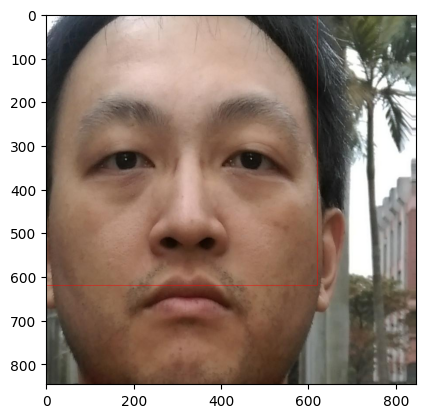

In [10]:
img_face =img[y:y+h, x:x+h]
plt.imshow(img_face)

In [11]:
class FaceLoad:
  def __init__(self,directory):
    self.directory = directory
    self.target_size= (160,160)
    self.X = []
    self.Y = []
    self.detector = MTCNN()
  
  def extract_face(self,file):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    res= self.detector.detect_faces(img)
    x,y,w,h = res[0]['box']
    x,y = abs(x),abs(y)
    face= img[y:y+h , x:x+w]
    face_arr =cv2.resize(face,self.target_size)
    return face_arr

  def load_faces(self,dir):
    FACES=[]
    for im_name in os.listdir(dir):
      path = dir+ im_name
      single_face = self.extract_face(path)
      FACES.append(single_face)
    return FACES
  
  def load_lables(self):
    for sub_dir in os.listdir(self.directory):
      path= self.directory + '/' +sub_dir+'/'
      FACES = self.load_faces(path)
      labels = [sub_dir for _ in range(len(FACES))]
      print(f"loaded successfully : {len(labels)}")
      self.X.extend(FACES)
      self.Y.extend(labels)

    return np.asarray(self.X),np.asarray(self.Y)
  
  def plot_img(self):
    for num, image in enumerate(self.X):
      ##ncols=10
      ##nrows=len(self.Y)
      plt.subplot(10,10,num+1)
      plt.imshow(image)

In [ ]:
faceloading = FaceLoad('/content/drive/MyDrive/Face_recognisation/DroneFace_dataset/Train_Aug')
X_train, Y_train = faceloading.load_lables()

In [13]:
#image1 = X_train[50]
#plt.imshow(image1)

In [14]:
!pip install keras-facenet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10370 sha256=be5efa9761e4a7ac0a9b9e549d6c7fc44774e07537b8f016394e5063b7361248
  Stored in directory: /root/.cache/pip/wheels/1d/d8/a9/85cf04ea29321d2afcb82c0caaafdca9195385f9d68cbc7185
Successfully built keras-facenet


In [15]:
from keras_facenet import FaceNet
embedder= FaceNet()

In [16]:
def get_embedding(face_img):
  face_img = face_img.astype('float32') #3d 160x160x3
  # add another dimension because tf requires 4d
  face_img = np.expand_dims(face_img, axis=0)#none x 160 x 160 x 3 

  yhat = embedder.embeddings(face_img)
  return yhat[0] # we will get 512 D array and it will then be compared

In [ ]:
emb_X_train =[]

for img in X_train:
  emb_X_train.append(get_embedding(img))

In [18]:
emb_X_train = np.asarray(emb_X_train)

In [19]:
len(emb_X_train)

1056

In [20]:
Base_Path = '/content/drive/MyDrive/Face_recognisation/DroneFace_dataset'
np.savez_compressed(os.path.join(Base_Path, 'face_embed_train.npz'), emb_X_train,Y_train)

In [21]:
np.savez_compressed(os.path.join(Base_Path, 'Y_train_labels.npz'),Y_train)

In [22]:
class FaceLoad_test_face:
  def __init__(self,directory):
    self.directory = directory
    self.target_size= (160,160)
    self.X = []
    self.Y = []
  
  def extract_face(self,file):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    face_arr =cv2.resize(img,self.target_size)
    return face_arr

  def load_faces(self,dir):
    FACES=[]
    for im_name in os.listdir(dir):
      path = dir+ im_name
      single_face = self.extract_face(path)
      FACES.append(single_face)
    return FACES
  
  def load_lables(self):
    for sub_dir in os.listdir(self.directory):
      path= self.directory + '/' +sub_dir+'/'
      FACES = self.load_faces(path)
      labels = [sub_dir for _ in range(len(FACES))]
      print(f"loaded successfully : {len(labels)}")
      self.X.extend(FACES)
      self.Y.extend(labels)

    return np.asarray(self.X),np.asarray(self.Y)
  
  def plot_img(self):
    for num, image in enumerate(self.X):
      ##ncols=10
      ##nrows=len(self.Y)
      plt.subplot(10,10,num+1)
      plt.imshow(image)

In [23]:
faceloading_test = FaceLoad_test_face('/content/drive/MyDrive/Face_recognisation/DroneFace_dataset/Test/height_1.5m')
X_test_1_5m, Y_test_1_5m = faceloading_test.load_lables()

loaded successfully : 31
loaded successfully : 31
loaded successfully : 31
loaded successfully : 31
loaded successfully : 31
loaded successfully : 31
loaded successfully : 30
loaded successfully : 31
loaded successfully : 31
loaded successfully : 31
loaded successfully : 32


In [24]:
#X_train = np.load('/content/drive/MyDrive/Face_recognisation/DroneFace_dataset/face_embed_train.npz')

In [25]:
#X_train['arr_0']

In [ ]:
emb_X_test_1_5 =[]

for img in X_test_1_5m:
  emb_X_test_1_5.append(get_embedding(img))

In [27]:
emb_X_test_1_5 = np.asarray(emb_X_test_1_5)

In [28]:
len(emb_X_test_1_5)

341

In [29]:
emb_X_test_1_5

array([[ 0.00868408,  0.01285211, -0.04980901, ..., -0.12785047,
        -0.03106002, -0.01528757],
       [ 0.10514954,  0.00338271, -0.01260129, ..., -0.04805619,
        -0.00461081, -0.03501514],
       [ 0.06657797,  0.0287963 , -0.04314249, ..., -0.0972811 ,
        -0.01782189, -0.00593404],
       ...,
       [ 0.02065542, -0.03072491, -0.03347019, ...,  0.04347792,
         0.04366315,  0.01152173],
       [ 0.03112175, -0.00203837, -0.04268534, ...,  0.03058325,
         0.03915339,  0.0185877 ],
       [ 0.01668931, -0.0052393 , -0.05791946, ...,  0.03383643,
         0.05042198,  0.0198852 ]], dtype=float32)

In [30]:
#emb_X_train= X_train['arr_0']

In [31]:
#emb_X_train

In [32]:
#Y_train = X_train['arr_1']

In [76]:
Base_Path = '/content/drive/MyDrive/Face_recognisation/DroneFace_dataset'
np.savez_compressed(os.path.join(Base_Path, 'face_embed_test_1_5.npz'), emb_X_test_1_5,Y_test_1_5m)

In [33]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(Y_train)
Y_train= encoder.transform(Y_train)
encoder.fit(Y_test_1_5m)
Y_test_1_5m= encoder.transform(Y_test_1_5m)

In [34]:
from sklearn.svm import SVC
model = SVC(kernel = 'linear', probability = True)

In [35]:
model.fit(emb_X_train, Y_train)

SVC(kernel='linear', probability=True)

In [36]:
y_preds = model.predict(emb_X_test_1_5)

In [37]:
from sklearn.metrics import accuracy_score

In [38]:
score_svm_1_5m = (accuracy_score(Y_test_1_5m,y_preds))*100

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test_1_5m,y_preds)


In [40]:
import seaborn as sns

In [41]:
score_svm_1_5m= round(score_svm_1_5m, ndigits=2).item()

In [42]:
score_svm_1_5m

78.59

In [43]:
title_svm = 'Accuracy Score at 1.5m height = ' + str(score_svm_1_5m) + '%'

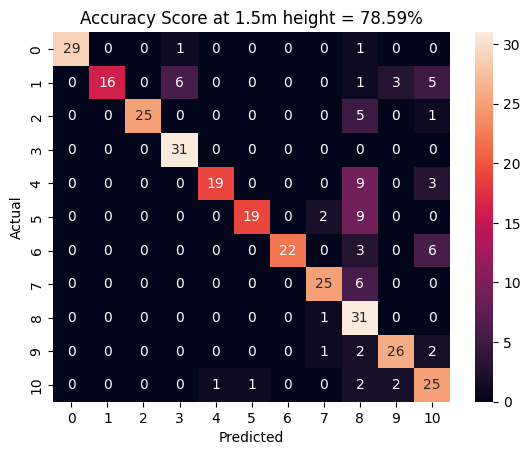

In [44]:
sns.heatmap(cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title(title_svm)
plt.show()

In [45]:
faceloading_test = FaceLoad_test_face('/content/drive/MyDrive/Face_recognisation/DroneFace_dataset/Test/height_3m')
X_test_3m, Y_test_3m = faceloading_test.load_lables()


loaded successfully : 31
loaded successfully : 31
loaded successfully : 31
loaded successfully : 31
loaded successfully : 31
loaded successfully : 31
loaded successfully : 31
loaded successfully : 31
loaded successfully : 31
loaded successfully : 31
loaded successfully : 30


In [ ]:
emb_X_test_3m =[]

for img in X_test_3m:
  emb_X_test_3m.append(get_embedding(img))

In [47]:
emb_X_test_3m = np.asarray(emb_X_test_3m)

In [48]:
encoder.fit(Y_test_3m)
Y_test_3m= encoder.transform(Y_test_3m)

In [49]:
y_preds_3m = model.predict(emb_X_test_3m)

In [50]:
score_svm_3m = (accuracy_score(Y_test_3m,y_preds_3m))*100
score_svm_3m= round(score_svm_3m, ndigits=2).item()
title_svm_3 = 'Accuracy Score at 3m height = ' + str(score_svm_3m) + '%'
score_svm_3m

76.76

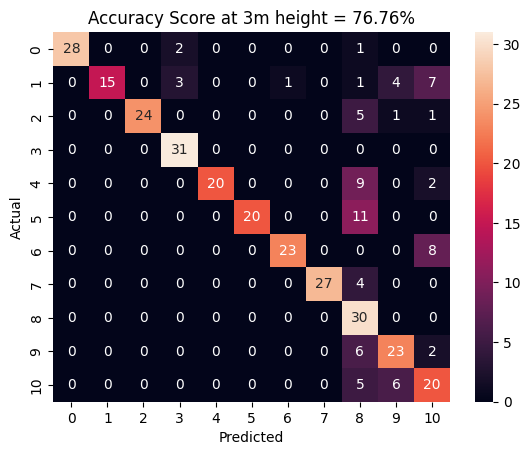

In [51]:
cm_3 = confusion_matrix(Y_test_3m,y_preds_3m)
sns.heatmap(cm_3, annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(title_svm_3)
plt.show()

In [52]:
faceloading_test = FaceLoad_test_face('/content/drive/MyDrive/Face_recognisation/DroneFace_dataset/Test/height_4m')
X_test_4m, Y_test_4m = faceloading_test.load_lables()

loaded successfully : 31
loaded successfully : 31
loaded successfully : 31
loaded successfully : 31
loaded successfully : 31
loaded successfully : 31
loaded successfully : 31
loaded successfully : 31
loaded successfully : 31
loaded successfully : 31
loaded successfully : 31


In [ ]:
emb_X_test_4m =[]

for img in X_test_4m:
  emb_X_test_4m.append(get_embedding(img))

In [54]:
emb_X_test_4m = np.asarray(emb_X_test_4m)
encoder.fit(Y_test_4m)
Y_test_4m= encoder.transform(Y_test_4m)
y_preds_4m = model.predict(emb_X_test_4m)
score_svm_4m = (accuracy_score(Y_test_4m,y_preds_4m))*100
score_svm_4m= round(score_svm_4m, ndigits=2).item()
title_svm_4 = 'Accuracy Score at 4m height = ' + str(score_svm_4m) + '%'
score_svm_4m

66.86

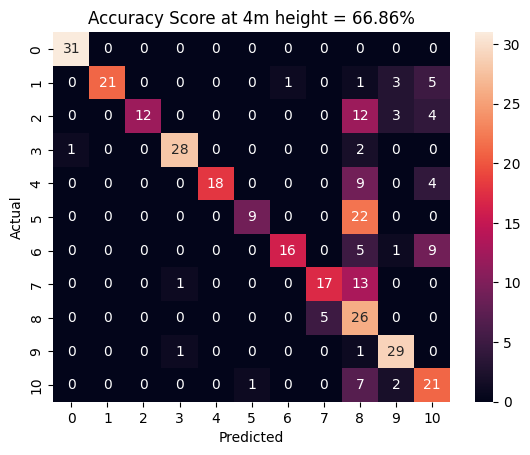

In [55]:
cm_4 = confusion_matrix(Y_test_4m,y_preds_4m)
sns.heatmap(cm_4, annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(title_svm_4)
plt.show()

In [56]:
faceloading_test = FaceLoad_test_face('/content/drive/MyDrive/Face_recognisation/DroneFace_dataset/Test/height_5m')
X_test_5m, Y_test_5m = faceloading_test.load_lables()

loaded successfully : 31
loaded successfully : 31
loaded successfully : 31
loaded successfully : 31
loaded successfully : 31
loaded successfully : 31
loaded successfully : 31
loaded successfully : 31
loaded successfully : 31
loaded successfully : 31
loaded successfully : 31


In [ ]:
emb_X_test_5m =[]

for img in X_test_5m:
  emb_X_test_5m.append(get_embedding(img))

In [58]:
emb_X_test_5m = np.asarray(emb_X_test_5m)
encoder.fit(Y_test_5m)
Y_test_5m= encoder.transform(Y_test_5m)
y_preds_5m = model.predict(emb_X_test_5m)
score_svm_5m = (accuracy_score(Y_test_5m,y_preds_5m))*100
score_svm_5m= round(score_svm_5m, ndigits=2).item()
title_svm_5 = 'Accuracy Score at 5m height = ' + str(score_svm_5m) + '%'
score_svm_5m

48.68

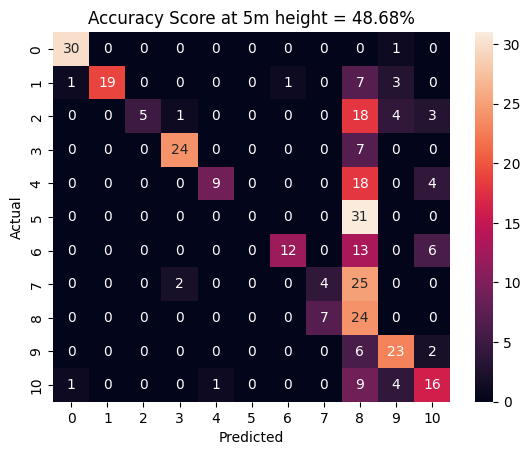

In [59]:
cm_5 = confusion_matrix(Y_test_5m,y_preds_5m)
sns.heatmap(cm_5, annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(title_svm_5)
plt.show()

In [77]:
np.savez_compressed(os.path.join(Base_Path, 'face_embed_test_3.npz'), emb_X_test_3m,Y_test_3m)
np.savez_compressed(os.path.join(Base_Path, 'face_embed_test_4.npz'), emb_X_test_4m,Y_test_4m)
np.savez_compressed(os.path.join(Base_Path, 'face_embed_test_5.npz'), emb_X_test_5m,Y_test_5m)


In [81]:
def recog_face(img):
  tes_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  
  res = detector.detect_faces(tes_img)

  #remove non face data (FP)
  res_final=[]
  for i in range(len(res)):
    a= res[i]['confidence']
    if a > 0.90:
      res_final.append(res[i])

      # for image with multiple faces
  for l in range(len(res_final)):
    tes_im = tes_img
    x,y,w,h = res_final[l]['box']
    tes_im = tes_im[y:y+h, x:x+w]
    tes_im = cv2.resize(tes_im, (160,160))

    plt.subplot(1,2,l+1)
    plt.imshow(tes_im)

    tes_im= get_embedding(tes_im)
    tes_im = [tes_im] #converting to 2d array
    ypreds = model.predict(tes_im)
    confi = model.decision_function(tes_im)
    max_confi = np.max(confi[0])
    if max_confi > 10.22:
      out = encoder.inverse_transform(ypreds)
      out= str(out)
      plt.title(out)
      #print(confi)
    else:
      plt.title('Match not found')

Testing Model on Raw Drone Footage

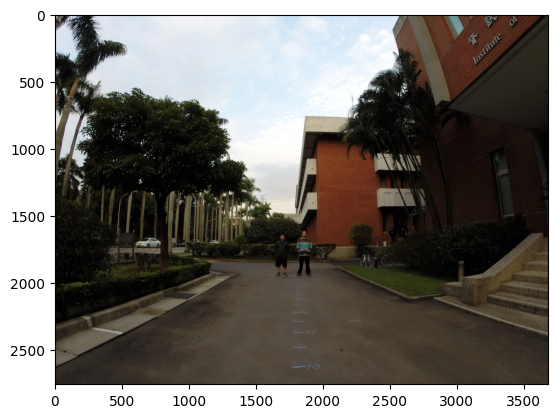

In [82]:
img_ab_1_5 = cv2.imread('/content/drive/MyDrive/Face_recognisation/Raw_Drone_image/ab_gp_0_eo_15.JPG')
change_color = cv2.cvtColor(img_ab_1_5, cv2.COLOR_BGR2RGB)
plt.imshow(change_color)

1/1 [==============================] - 0s 95ms/step


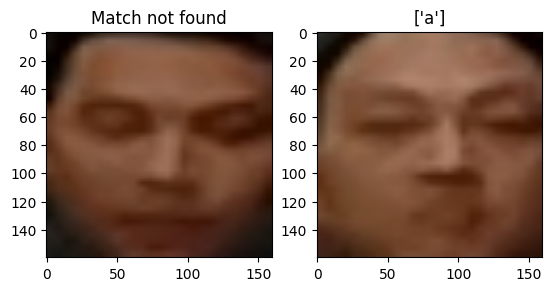

In [83]:
recog_face(img_ab_1_5)

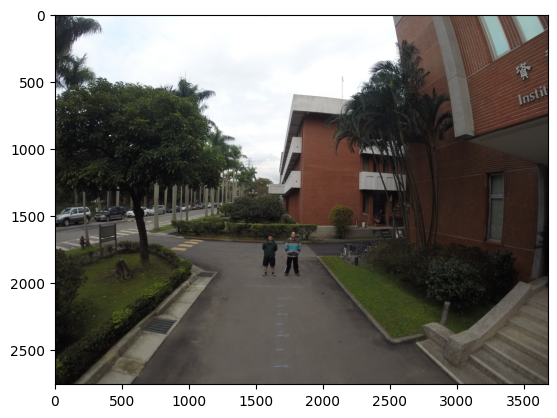

In [84]:
img_ab_3 = cv2.imread('/content/drive/MyDrive/Face_recognisation/Raw_Drone_image/ab_gp_3_eo_18.JPG')
change_color = cv2.cvtColor(img_ab_3, cv2.COLOR_BGR2RGB)
plt.imshow(change_color)

1/1 [==============================] - 0s 98ms/step


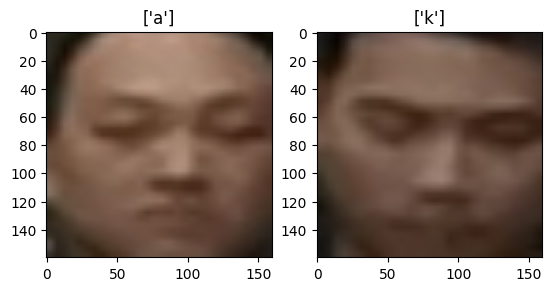

In [85]:
recog_face(img_ab_3)

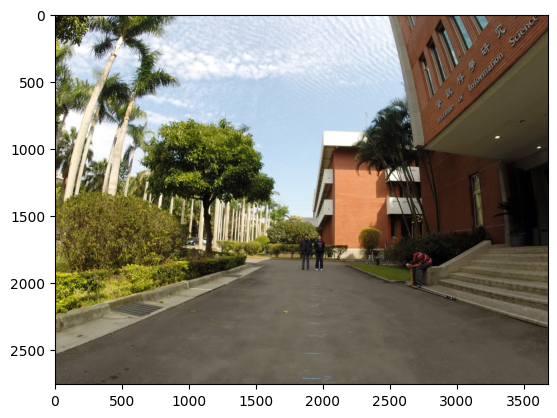

In [86]:
img_cd = cv2.imread('/content/drive/MyDrive/Face_recognisation/Raw_Drone_image/cd_gp_0_eo_10.JPG')
change_color = cv2.cvtColor(img_cd, cv2.COLOR_BGR2RGB)
plt.imshow(change_color)

1/1 [==============================] - 0s 101ms/step


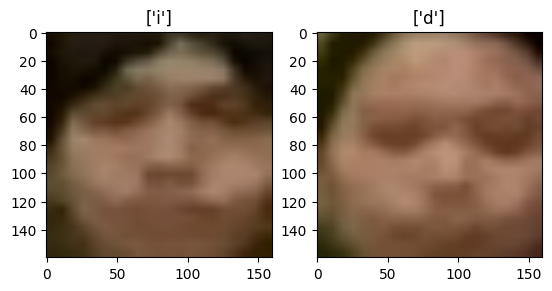

In [87]:
recog_face(img_cd)

In [88]:
#correctly identified

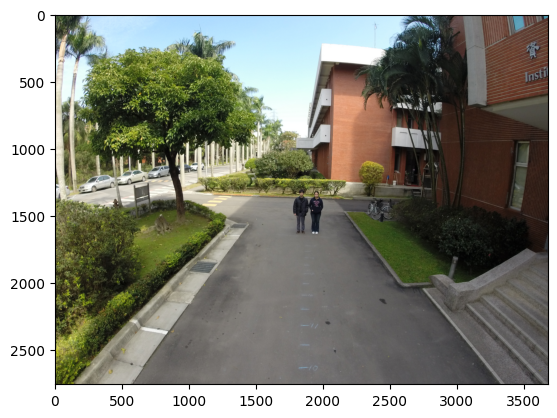

In [89]:
img_cd_3 = cv2.imread('/content/drive/MyDrive/Face_recognisation/Raw_Drone_image/cd_gp_3_eo_15.JPG')
change_color = cv2.cvtColor(img_cd_3, cv2.COLOR_BGR2RGB)
plt.imshow(change_color)

1/1 [==============================] - 0s 110ms/step


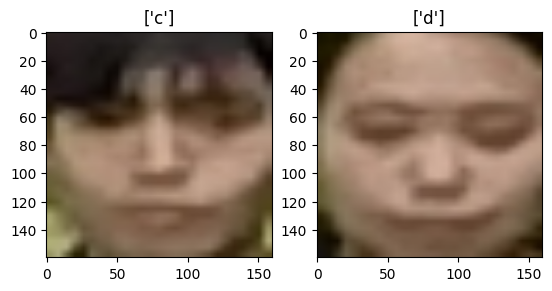

In [90]:
recog_face(img_cd_3)

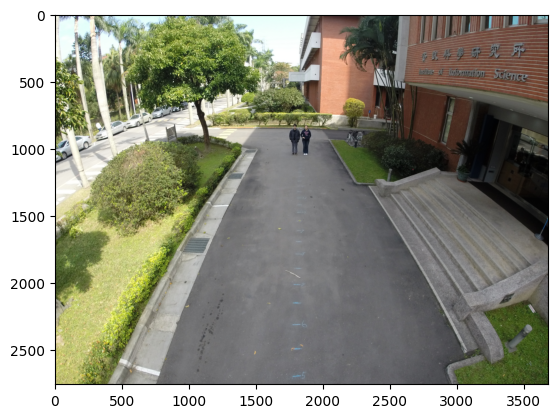

In [91]:
img_cd_4 = cv2.imread('/content/drive/MyDrive/Face_recognisation/Raw_Drone_image/cd_gp_4_eo_07.JPG')
change_color = cv2.cvtColor(img_cd_4, cv2.COLOR_BGR2RGB)
plt.imshow(change_color)

1/1 [==============================] - 0s 88ms/step


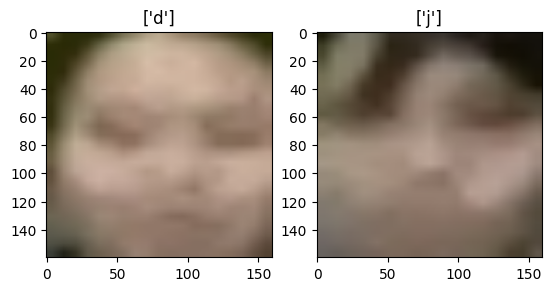

In [92]:
recog_face(img_cd_4)

In [93]:
#only one face correctly identified

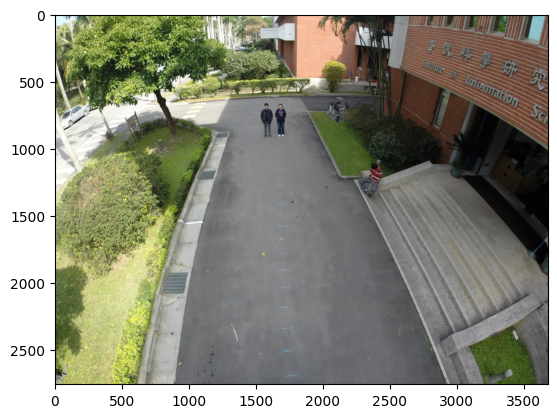

In [94]:
# checking for worst case
img_cd_5 = cv2.imread('/content/drive/MyDrive/Face_recognisation/Raw_Drone_image/cd_gp_5_eo_10.JPG')
change_color = cv2.cvtColor(img_cd_5, cv2.COLOR_BGR2RGB)
plt.imshow(change_color)

1/1 [==============================] - 0s 164ms/step


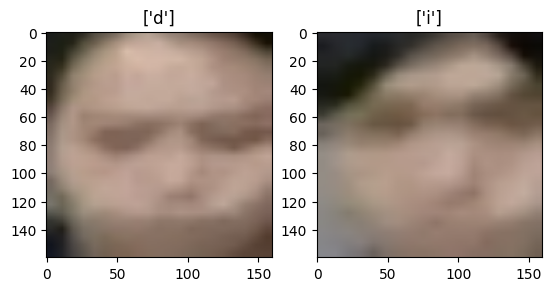

In [95]:
recog_face(img_cd_5)

In [96]:
#only one correctly identified

In [97]:
import pickle
pickle.dump(model, open('svm_face_rec_dF.pkl', 'wb'))

In [98]:
from google.colab import files
files.download('svm_face_rec_dF.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

It is observed that the best results are at a height of 3 meters and distance range of 5 to 14 meters